In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

# loading dataset into the program
dataset1 = pd.read_csv('London 2000-01-01 to 2024-01-31.csv', index_col="datetime")
dataset2 = pd.read_csv(r'tfl-daily-cycle-hires.csv', index_col="Day", parse_dates=["Day"])

# define the features we want to predict, focus on only max temperature now
features_to_pred = ['tempmax']
#features_to_pred = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'precip', 'snowdepth', 'windspeed', 'winddir', 'cloudcover', 'visibility', 'Number of Bicycle Hires']

# filter dataset1 from 2010.07.30 to 2024.01.31 to fit with dataset2
start_date = pd.to_datetime('2010-07-30')
dataset1.index = pd.to_datetime(dataset1.index)
dataset1_filtered = dataset1[(dataset1.index >= start_date)]

# delete useless columns and columns with too many NaN values
dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust', 
                                'preciptype', 'precipprob', 'solarradiation', 
                                'solarenergy', 'uvindex', 'sunrise', 
                                'sunset', 'conditions', 'description',	
                                'icon', 'stations', 'sunset'], 
                       inplace=True)

# combining the two datasets
merged_data = pd.merge(dataset1_filtered, dataset2, left_index=True, right_index=True, how='outer')

# change the values of bike hires to float
merged_data['Number of Bicycle Hires'] = merged_data['Number of Bicycle Hires'].apply(lambda x: float(x.replace(',', '')))

# show the merged dataset
merged_data

C:\Users\12783\AppData\Local\Temp\ipykernel_49264\3621105755.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',


,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,Number of Bicycle Hires
datetime,,,,,,,,,,,,,,,,,,,
2010-07-30,22.3,14.0,17.9,22.3,14.0,17.9,10.5,63.0,0.000,0.00,0.0,0.0,21.3,250.6,1014.8,60.3,32.9,0.65,6897.0
2010-07-31,23.5,17.6,20.1,23.5,17.6,20.1,14.3,71.3,1.995,8.33,0.0,0.0,22.7,242.6,1011.6,64.1,31.1,0.68,5564.0
2010-08-01,22.8,15.3,18.8,22.8,15.3,18.8,11.7,64.8,0.000,0.00,0.0,0.0,14.6,261.1,1013.2,62.3,38.7,0.71,4303.0
2010-08-02,22.1,16.3,18.9,22.1,16.3,18.9,11.1,60.9,0.299,4.17,0.0,0.0,15.1,344.5,1016.6,63.3,36.6,0.75,6642.0
2010-08-03,21.8,13.0,18.0,21.8,13.0,18.0,11.6,67.3,0.000,0.00,0.0,0.0,20.0,247.9,1016.0,54.3,30.7,0.75,7966.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,8.6,1.1,5.0,6.6,-0.6,3.3,2.0,81.8,0.000,0.00,0.0,0.0,18.1,180.3,1032.7,33.1,15.9,0.56,16959.0
2024-01-28,11.5,3.1,7.0,11.5,0.5,5.4,4.1,82.4,0.000,0.00,0.0,0.0,13.8,169.7,1022.7,33.5,15.2,0.59,15540.0
2024-01-29,12.1,8.6,10.8,12.1,7.2,10.5,8.8,87.3,0.000,0.00,0.0,0.0,20.8,182.3,1022.0,95.9,8.4,0.62,22839.0


In [2]:
# Filling in the missing data in columns by the previous day values
merged_data=merged_data.ffill()

# Checking again the number of missing data in every column after filling in the missing values
print(merged_data.isnull().sum())

tempmax                    0
tempmin                    0
temp                       0
feelslikemax               0
feelslikemin               0
feelslike                  0
dew                        0
humidity                   0
precip                     0
precipcover                0
snow                       0
snowdepth                  0
windspeed                  0
winddir                    0
sealevelpressure           0
cloudcover                 0
visibility                 0
moonphase                  0
Number of Bicycle Hires    0
dtype: int64


In [3]:
# Checking datatypes of each column to ensure are of correct types for ML processing
print(merged_data.dtypes)

tempmax                    float64
tempmin                    float64
temp                       float64
feelslikemax               float64
feelslikemin               float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipcover                float64
snow                       float64
snowdepth                  float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
moonphase                  float64
Number of Bicycle Hires    float64
dtype: object


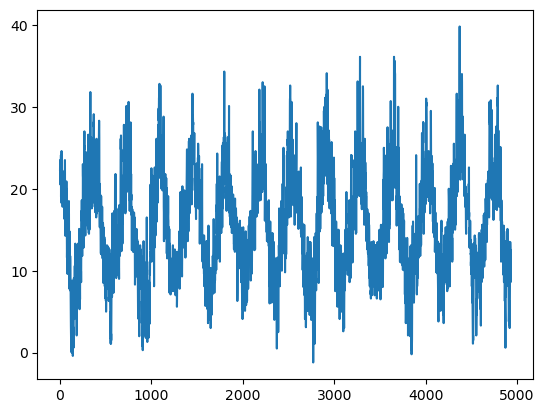

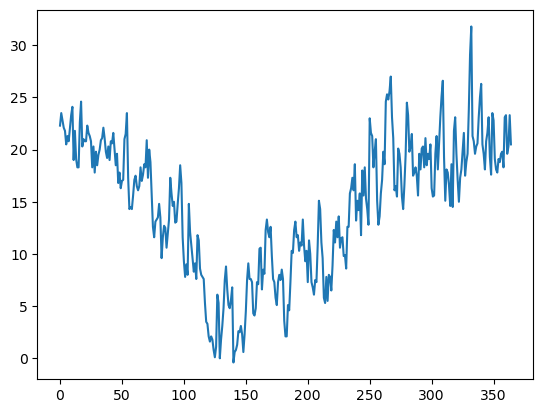

In [4]:
# Analyze the read weather data and draw temperature data
tempmax = merged_data.loc[:, 'tempmax']

plt.figure()
plt.plot(range(len(tempmax)), tempmax)	# paint all data
plt.show()

plt.figure()
plt.plot(range(365), tempmax[:365])  # paint data of first 365 days
plt.show()

In [5]:
# Prepare the data required for the model
# Normalise data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data)
scaled_data = pd.DataFrame(scaled_data, columns=merged_data.columns)

In [6]:
# Specify the ratio of training set, validation set, and test set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the size of the training, validation, and testing sets
train_size = int(len(scaled_data) * train_ratio)
val_size = int(len(scaled_data) * val_ratio)

# # Slice the dataset
# data_train = scaled_data[:train_size]
# data_val = scaled_data[train_size:train_size+val_size]
# data_test = scaled_data[train_size+val_size:]

# # Output the size of each part of the dataset
# print("Size of training set: ", len(data_train))
# print("Size of validation set: ", len(data_val))
# print("Size of testing set: ", len(data_test))

lookback = 30   # use the data of last 30 days to predict that of next day

# generate x_train and y_train
x_train = []
y_train = []
for i in range(lookback, train_size+1):
    x_train.append(scaled_data[i - lookback:i])
    y_train.append(scaled_data.loc[i, features_to_pred])
x_train, y_train = np.array(x_train), np.array(y_train)

# generate x_val and y_val
x_val = []
y_val = []
for i in range(train_size, train_size+val_size+1):
    x_val.append(scaled_data[i - lookback:i])
    y_val.append(scaled_data.loc[i, features_to_pred])
x_val, y_val = np.array(x_val), np.array(y_val)

# generate x_test and y_test
x_test = []
y_test = []
for i in range(train_size+val_size, len(scaled_data)):
    x_test.append(scaled_data[i - lookback:i])
    y_test.append(scaled_data.loc[i, features_to_pred])
x_test, y_test = np.array(x_test), np.array(y_test)

In [7]:
# A common sense based, non machine learning method  is 
# used to calculate the MAE (Mean Absolute Error) of a 
# common sense based method that always predicts that 
# the next day's data is equal to the previous day's data.
data_to_pred = merged_data.loc[:, features_to_pred]
diff_data_val = np.diff(data_to_pred, axis=0)[lookback+train_size:train_size+val_size]
mae = np.mean(np.abs(diff_data_val), axis=0)

pd.DataFrame([mae],columns=data_to_pred.columns)

,tempmax
0,1.970423


In [8]:
std = data_to_pred[:].std(axis=0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, None, 128)         57216     
                                                                 
 gru_11 (GRU)                (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 94,529
Trainable params: 94,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
27/27 [==============================] - 11s 203ms/step - loss: 0.3912 - val_loss: 0.3479
Epoch 2/20
27/27 [==============================] - 4s 165ms/step - loss: 0.3395 - val_loss: 0.3320
Epoch 3/20
27/27 [==============================] - 5s 169ms/step - loss: 0.3316 - val_loss: 0.3313
Epoch 4/20
27

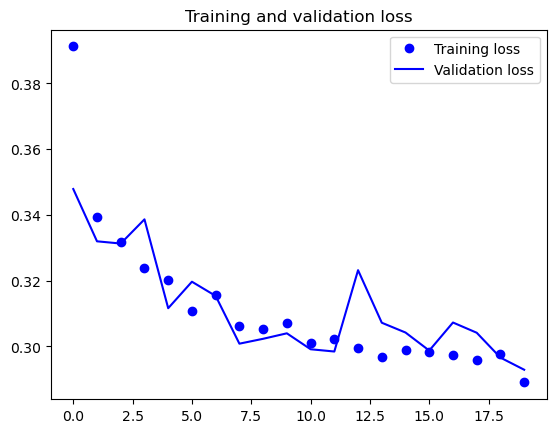

In [15]:
# Train and evaluate a stacked GRU model using dropout regularization
model = Sequential()
model.add(layers.GRU(128, 
                     dropout=0.2, 
                     recurrent_dropout=0.5,
                     return_sequences=True, 
                     input_shape=(None, scaled_data.shape[-1])))
model.add(layers.GRU(64, 
                     activation='relu', 
                     dropout=0.2, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(data_to_pred.shape[-1]))
model.summary()

# Compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mae')
history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 64)          21504     
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 120,449
Trainable params: 120,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
27/27 [==============================] - 12s 219ms/step - loss: 0.4840 - val_loss: 0.4090
Epoch 2/20
27/27 [==============================] - 5s 203ms/step - loss: 0.3816 - val_loss: 0.3955
Epoch 3/20
27/27 [==============================] - 6s 211ms/step - loss: 0.3555 - val_loss: 0.3494
Epoch 4/20


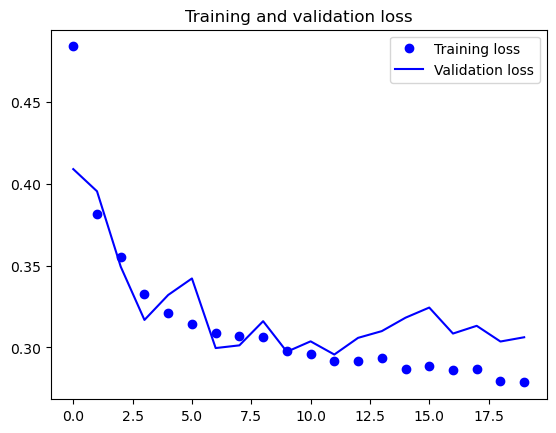

In [16]:
# Train and evaluate a stacked LSTM model using dropout regularization
model = Sequential()
model.add(layers.LSTM(64, 
                      dropout=0.1, 
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, scaled_data.shape[-1])))
model.add(layers.LSTM(128, 
                      activation='relu', 
                      dropout=0.1,
                      recurrent_dropout=0.5))
model.add(layers.Dense(data_to_pred.shape[-1]))
model.summary()

# compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.0025), 
              loss='mae')
history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
# test the model
score = model.evaluate(x_test, y_test, verbose=0)
# denormalization the error, which shows the average error
# measured in Celsius degree.
print('Test error:', score*std)

Test error: tempmax    1.943559
dtype: float64
